# Introduction  
  
In this kernel, I try 2 layers stacking.  
Using models are NN, LGB, XGB, CAT.  
The score not so high but low overfitting.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/train.csv


# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

def get_4020_acc(df,counter_dict):
    
    for e in ['Cauldron Filler (Assessment)','Bird Measurer (Assessment)','Mushroom Sorter (Assessment)','Chest Sorter (Assessment)']:
        
        Assess_4020 = df[(df.event_code == 4020) & (df.title==activities_map[e])]   
        true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
        false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

        measure_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
        counter_dict[e+"_4020_accuracy"] += (counter_dict[e+"_4020_accuracy"] + measure_assess_accuracy_) / 2.0
    
    return counter_dict

In [6]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    
    train['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), train['type'], train['world']))
    test['type_world'] = list(map(lambda x, y: str(x) + '_' + str(y), test['type'], test['world']))
    all_type_world = list(set(train["type_world"].unique()).union(test["type_world"].unique()))
    
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map,all_type_world

In [7]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    assess_4020_acc_dict = {'Cauldron Filler (Assessment)_4020_accuracy':0,
                                'Mushroom Sorter (Assessment)_4020_accuracy':0,
                                'Bird Measurer (Assessment)_4020_accuracy':0,
                                'Chest Sorter (Assessment)_4020_accuracy':0 }
    
    game_time_dict = {'Clip_gametime':0, 'Game_gametime':0, 'Activity_gametime':0, 'Assessment_gametime':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    
    # Newly added features
    accumulated_game_miss = 0
    Cauldron_Filler_4025 = 0
    mean_game_round = 0
    mean_game_duration = 0 
    mean_game_level = 0
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    chest_assessment_uncorrect_sum = 0
    
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    type_world_count: Dict[str, int] = {w_eve: 0 for w_eve in all_type_world}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
        if session_type=="Activity":
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
            
        if session_type=="Game":
            
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            game_s = session[session.event_code == 2030]   
            misses_cnt = cnt_miss(game_s)
            accumulated_game_miss += misses_cnt
            
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) /2.0
            except:
                pass
            
            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) /2.0
            except:
                pass
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(game_time_dict.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(assess_4020_acc_dict.copy())
            features.update(type_world_count.copy())
            
            #features['installation_session_count'] = sessions_count
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['chest_assessment_uncorrect_sum'] = chest_assessment_uncorrect_sum
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count),
                                ('var_type_world', type_world_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            
            features['Cauldron_Filler_4025'] = Cauldron_Filler_4025/counter if counter > 0 else 0
            ####################
            Assess_4025 = session[(session.event_code == 4025) & (session.title=='Cauldron Filler (Assessment)')]   
            true_attempts_ = Assess_4025['event_data'].str.contains('true').sum()
            false_attempts_ = Assess_4025['event_data'].str.contains('false').sum()

            cau_assess_accuracy_ = true_attempts_/(true_attempts_+false_attempts_) if (true_attempts_+false_attempts_) != 0 else 0
            Cauldron_Filler_4025 += cau_assess_accuracy_
            
            chest_assessment_uncorrect_sum += len(session[session.event_id=="df4fe8b6"])
            
            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1])/2.0
            ##############################
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # end session_type=="Assessment"
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        type_world_count = update_counters(type_world_count, 'type_world')
        
        assess_4020_acc_dict = get_4020_acc(session , assess_4020_acc_dict)
        game_time_dict[session_type+'_gametime'] = (game_time_dict[session_type+'_gametime'] + (session['game_time'].iloc[-1]/1000.0))/2.0
        
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [8]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [9]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        #self.params = self.get_params()
        self.params = self.set_params(ps)
        self.oof_pred, self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return oof_pred, y_pred, loss_score, model

In [10]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        x_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_train.columns]
        x_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_val.columns]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['max_depth']=int(ps['max_depth'])
        
        return params

In [11]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}
        return params
    
    def set_params(self, ps={}):
        return self.get_params()

In [12]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params
    
    def set_params(self, ps={}):
        return self.get_params()

In [13]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None
    def set_params(self, ps={}):
        return self.get_params()

In [14]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None
    def set_params(self, ps={}):
        return self.get_params()

In [15]:
# read data
train, test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [16]:
# get usefull dict with maping encode
#train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map,all_type_world = encode_title(train, test, train_labels)

In [17]:
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [18]:
reduce_train.to_csv('reduce_train.csv', index=False)
reduce_test.to_csv('reduce_test.csv', index=False)
#categoricals.to_csv('categoricals.csv', index=False)

In [19]:
del train
del test

In [20]:
reduce_train.shape

(17690, 931)

0.0026939774600629332


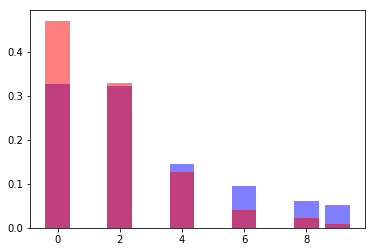

0.0026939774600629332

In [21]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [22]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [23]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999999


invalid value encountered in true_divide


2: FEAT_A: 2050 FEAT_B: 2040 - Correlation: 0.9965259434878118
3: FEAT_A: 2050 FEAT_B: 73757a5e - Correlation: 0.9998050146713992
4: FEAT_A: 2050 FEAT_B: 2b9272f4 - Correlation: 0.9999839030068793
5: FEAT_A: 2050 FEAT_B: 08fd73f3 - Correlation: 0.9966123918733654
6: FEAT_A: 2050 FEAT_B: dcaede90 - Correlation: 0.9965259434878118
7: FEAT_A: 2050 FEAT_B: 26fd2d99 - Correlation: 0.9965084543995759
8: FEAT_A: 2050 FEAT_B: 37c53127 - Correlation: 1.0
9: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3021 - Correlation: 0.9998050146713992
10: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2020 - Correlation: 0.9965084543995759
11: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2040 - Correlation: 0.9965259434878118
12: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2050 - Correlation: 1.0
13: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_2030 - Correlation: 0.9966123918733654
14: FEAT_A: 2050 FEAT_B: Scrub-A-Dub_3121 - Correlation: 0.9999839030068793
15: FEAT_A: 4230 FEAT_B: 4235 - Correlation: 0.9999995197498746
16: FEAT_A: 4230 FEAT_B: ad148f58 - Correlatio

In [24]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346 0.006732930476733109
003cd2ee 0.0 0.0
2ec694de 0.008988128886376484 0.0
7fd1ac25 0.01978518937252685 0.0
e4d32835 0.0013001695873374789 0.0
bfc77bd6 0.012832108535895986 0.0
ecc6157f 0.007292255511588468 0.0
17ca3959 0.0 0.0
0ce40006 0.0008479366873940079 0.0
dcb1663e 0.0 0.0
ab4ec3a4 0.0009044657998869418 0.0
4074bac2 0.0 0.0
13f56524 0.04392312040700961 0.0
29a42aea 0.004070096099491238 0.0
119b5b02 0.0002826455624646693 0.0
01ca3a3c 0.0004522328999434709 0.0
611485c5 0.0013566986998304127 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
a8cc6fec 0.0 0.0
6aeafed4 0.14703222159412097 0.008 0.0
5dc079d8 0.0 0.0
1b54d27f 0.0007348784624081402 0.0
Clip_gametime 0.0 0.0
Bubble Bath_4080 0.004070096099491238 0.0
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Chest Sorter (Assessment)_4080 0.012832108535895986 0.0
Happy Camel_4080 0.0008479366873940079 0.0
Air Show_4080 0.0 0.0
Pan Balance_4080 0.0013001695873374789 0

In [25]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape
#ajusted_test = reduce_test.copy()

(17690, 387)

# Model training

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | subsam... |
-------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.845938	valid_1's rmse: 0.977688
[200]	training's rmse: 0.754701	valid_1's rmse: 0.980691
Early stopping, best iteration is:
[116]	training's rmse: 0.828452	valid_1's rmse: 0.976582
Partial score of fold 0 is: 0.596738339599963
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.84338	valid_1's rmse: 0.993055
Early stopping, best iteration is:
[76]	training's rmse: 0.872893	valid_1's rmse: 0.992101
Partial score of fold 1 is: 0.5857667717531403
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.843457	valid_1's rmse: 0.990775
[200]	training's rmse: 0.754127	valid_1's rmse: 0.993518
Early stopping, best iteration is:
[120]	training's rmse: 

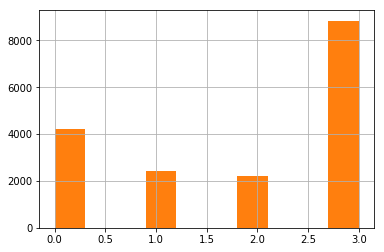

In [26]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    lgb_model= Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals,ps=params)
    print('kappa: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.01, 0.1),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
}

LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
import warnings
init_points = 16
n_iter = 16
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

Found `n_estimators` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.971828	valid_1's rmse: 1.00717
[200]	training's rmse: 0.915175	valid_1's rmse: 0.983087
[300]	training's rmse: 0.880864	valid_1's rmse: 0.977758
[400]	training's rmse: 0.853118	valid_1's rmse: 0.9762
[500]	training's rmse: 0.82926	valid_1's rmse: 0.976467
[600]	training's rmse: 0.807817	valid_1's rmse: 0.976333
Early stopping, best iteration is:
[540]	training's rmse: 0.820541	valid_1's rmse: 0.975986
Partial score of fold 0 is: 0.6010321638455711
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.968879	valid_1's rmse: 1.00929
[200]	training's rmse: 0.91133	valid_1's rmse: 0.990846
[300]	training's rmse: 0.876251	valid_1's rmse: 0.987888
[400]	training's rmse: 0.848871	valid_1's rmse: 0.987305
[500]	training's rmse: 0.824544	valid_1's rmse: 0.987734
Early stopping, best iteration is:
[429]	training's rmse: 0.841457	valid_1's rmse: 0.987067
Partial score of fold 1 

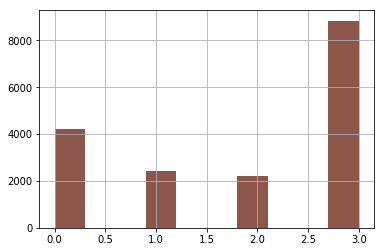

In [27]:
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals, ps=LGB_BO.max['params'])

Series.base is deprecated and will be removed in a future version


[0]	train-rmse:1.85623	val-rmse:1.85705
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.0178	val-rmse:1.15218
[200]	train-rmse:0.748606	val-rmse:1.01058
[300]	train-rmse:0.640051	val-rmse:0.98722
[400]	train-rmse:0.574536	val-rmse:0.983104
[500]	train-rmse:0.535421	val-rmse:0.982939
Stopping. Best iteration:
[454]	train-rmse:0.550558	val-rmse:0.982736

Partial score of fold 0 is: 0.5902976032315507
[0]	train-rmse:1.85615	val-rmse:1.85764
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.01309	val-rmse:1.16798
[200]	train-rmse:0.743602	val-rmse:1.02575
[300]	train-rmse:0.635774	val-rmse:1.00201
[400]	train-rmse:0.577681	val-rmse:0.997401
[500]	train-rmse:0.539739	val-rmse:0.997492
Stopping. Best iteration:
[446]	train-rmse:0.557437	val-rmse:0.997015

Partial score of

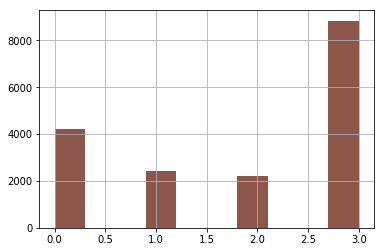

In [28]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

0:	learn: 1.2472272	test: 1.2475221	best: 1.2475221 (0)	total: 361ms	remaining: 30m 4s
100:	learn: 0.9949520	test: 1.0193874	best: 1.0193874 (100)	total: 16.4s	remaining: 13m 17s
200:	learn: 0.9516122	test: 0.9988753	best: 0.9988753 (200)	total: 32.5s	remaining: 12m 56s
300:	learn: 0.9208086	test: 0.9905148	best: 0.9905148 (300)	total: 49.3s	remaining: 12m 49s
400:	learn: 0.8871462	test: 0.9848748	best: 0.9848748 (400)	total: 1m 5s	remaining: 12m 33s
500:	learn: 0.8605635	test: 0.9825447	best: 0.9825447 (500)	total: 1m 21s	remaining: 12m 15s
600:	learn: 0.8374680	test: 0.9809891	best: 0.9809891 (600)	total: 1m 38s	remaining: 11m 58s
700:	learn: 0.8169417	test: 0.9800077	best: 0.9799860 (699)	total: 1m 55s	remaining: 11m 46s
800:	learn: 0.7981587	test: 0.9798398	best: 0.9797768 (766)	total: 2m 11s	remaining: 11m 30s
900:	learn: 0.7803339	test: 0.9795674	best: 0.9794455 (862)	total: 2m 28s	remaining: 11m 13s
1000:	learn: 0.7643023	test: 0.9793895	best: 0.9793895 (1000)	total: 2m 44s	rema

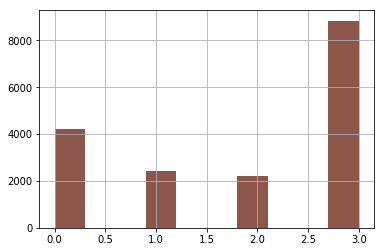

In [29]:
cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.


(17690, 392)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               78600     
_________________________________________________________________
layer_normalization (LayerNo (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
layer_normalization_1 (Layer (None, 100)               200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)    

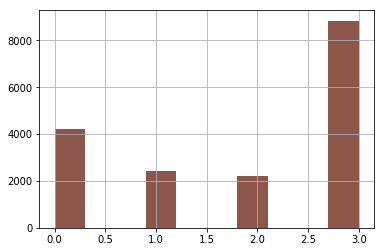

In [30]:
#cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

# Median Stacking models

## memo  
My first try is simple median stacking. Just use raw prediction data.  

lgb = lgb_model.y_pred
cat = cat_model.y_pred
xgb = xgb_model.y_pred
nn = nn_model.y_pred

concat = sample_submission.drop("accuracy_group", axis=1)
concat["lgb"] = lgb
concat["cat"] = cat
concat["xgb"] = xgb
concat["nn"] = nn

concat.head()

In [31]:
#concat.shape

In [32]:
#concat['median'] = concat.iloc[:, 1:].median(axis=1)

In [33]:
#final_pred=concat["median"]

dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)

# Stacking models

In [34]:
#sub model
import numpy as np
import pandas as pd
#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

class Model2Linear:

    def __init__(self):
        self.model = None
        self.scaler = None

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.scaler = StandardScaler()
        self.scaler.fit(tr_x)
        tr_x = self.scaler.transform(tr_x)
        self.model = Ridge()
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        x = self.scaler.transform(x)
        pred = self.model.predict(x)
        return pred

In [35]:
train_x = reduce_train.drop(["installation_id", "accuracy_group"],axis=1)
train_y = reduce_train["accuracy_group"]

In [36]:
#from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        #model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.oof_pred[va_idx]
        preds.append(pred)
        pred_test = model.y_pred
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test

In [37]:
#for attr in dir(lgb_model.__init__):
#    if callable(getattr(lgb_model.__init__, str(attr))):
#        print(attr)

In [38]:
print(lgb_model.y_pred)

[ 2.18068038  2.71382171  2.31838337  1.89889971  1.82758286  2.28066765
  1.68685053  1.86519308  0.34752583  1.00100099  2.14744238  1.77239758
  2.193064    2.38311114  0.81024001  1.27630131  2.14131819  1.92161654
  2.76031266  1.99871579  2.12539527  1.75096208  2.18335078  2.5174695
  1.45235426  0.88785893  2.46057802  1.4149322   1.98737722  2.44812231
  0.27115814  1.86590142  0.37717168  1.26410088  2.57071936  2.03946562
  0.68446935  1.53297937  2.12500382  0.91420114  1.76659537  2.03362076
  0.70711792  1.28326599  2.25619535  2.48044898  2.137893    0.96436011
  2.32568331  2.37388824  0.17198205  1.18557448  2.58934358  2.41662527
  2.16759641  1.20434047  0.18694111  1.92617584  1.51130951  0.94967475
  1.86059785  1.98274942  1.31923009  2.08176128  1.18466468  2.34119962
  2.31474795  2.25550639  1.41231044  0.32938455  1.92451609  2.43872031
  1.32107323  2.05196435  2.32786087  2.34009394  1.77551166  2.40272383
  2.02279814  1.30631718  2.05622392  1.55610661  2.

In [39]:
print(xgb_model.y_pred)

[2.2423043  2.51824874 2.32587478 2.07301134 1.83499292 2.20469362
 1.50762552 1.4876648  0.57155286 0.81924877 2.11794716 1.70977017
 2.00017807 2.38337231 0.83881487 1.50267175 2.13414562 1.85045847
 2.73098296 1.91281953 2.01065606 1.58209366 2.09495625 2.1309742
 1.041789   1.02932601 1.86778167 1.50224295 1.79861307 2.41179606
 0.54533494 1.55515447 0.39702424 1.1110895  2.4865323  2.1966837
 0.87114038 1.51166312 1.61514735 1.05094579 1.66420266 1.46805413
 0.96102829 1.22307314 1.87580734 2.33949623 2.15156496 1.22635543
 2.23464119 2.32940024 0.3865218  1.3897329  2.52725029 2.36690956
 1.76796883 1.18831196 0.42679524 2.01408845 1.35572144 0.88108769
 1.94018781 1.60452271 0.96503988 1.99169376 1.29266807 2.29577681
 1.85601357 2.37312689 1.0426396  0.32065721 1.33985427 2.30074865
 1.42482954 1.71374765 2.41447237 2.21737805 1.58424625 2.24214202
 1.96396348 1.36541975 1.6219053  1.56495352 2.3306815  2.52491355
 1.8906849  2.13630271 2.05152339 0.4938774  2.52000591 2.094676

In [40]:
print(cat_model.y_pred)

[ 2.20189137  2.6735855   2.31471881  2.03151571  1.88154426  2.33420868
  1.60699657  1.70868044  0.47305051  1.22841702  2.15219131  1.88634951
  2.27246161  2.28916318  0.67889841  1.2394547   2.00302079  1.94537443
  2.74311558  2.00324798  1.86568521  1.83117434  2.06407341  2.37625872
  1.30516165  1.11622325  2.44510668  1.49546185  2.00161479  2.34044586
  0.77831549  1.53593449  0.48143955  1.25711835  2.58569671  2.22124543
  0.47403192  1.70022837  2.02206333  0.81493304  1.78198376  1.92777828
  0.58759581  1.46129796  2.12835291  2.49592089  2.17945537  1.15348355
  2.32084809  2.38848053 -0.07269071  0.85539306  2.5118389   2.39654613
  2.2384093   1.30695171  0.17080599  2.05641027  1.71990037  0.79957183
  1.91246629  1.96119547  1.15629654  2.0506857   1.48357514  2.39298152
  2.22213924  2.1261792   1.2434744   0.39907874  1.83502617  2.32720062
  1.2970673   2.00861618  2.38041389  2.31206187  1.67717082  2.41914813
  1.99779868  1.37195646  1.87859652  1.53165203  2

In [41]:
print(nn_model.y_pred)

[2.53581542 2.68260652 2.39942941 2.54262412 2.34701592 2.71188259
 2.0958434  2.1693055  0.27966329 0.81915407 2.14865151 2.3891567
 2.48634079 2.47660705 0.49202851 1.86244789 1.94541653 2.3787846
 2.6181457  2.09991795 2.2596972  2.55060297 2.23537144 2.34398511
 1.22973461 0.67010719 2.51872033 1.02701327 2.15925172 2.35379136
 0.1848483  2.31946498 0.27875059 1.00429431 2.54766425 2.27015778
 0.406938   1.82956335 2.06385541 1.46080607 1.83402178 1.95142993
 1.26859593 1.4982295  2.45895508 2.67458826 1.18677862 1.30833939
 2.42422011 2.58792108 0.2290515  1.34024093 2.57795304 2.58120748
 2.47631475 1.12490935 0.36670125 2.50663733 1.50460322 0.97321814
 2.29434267 2.10290483 0.82124987 1.94599056 0.68049467 2.65677673
 2.31533232 2.15583199 1.96149838 0.68468684 2.04917997 2.53594404
 1.30041417 0.22075969 2.43322697 2.53648323 2.17145237 2.53627521
 2.14693114 1.53825212 0.89201113 1.99323159 2.43903989 2.50739124
 1.86673936 2.44109395 2.31928283 0.28169324 2.64013284 2.412848

In [42]:
# 1層目のモデル
# pred_train_1a, pred_train_1bは、学習データのクロスバリデーションでの予測値
# pred_test_1a, pred_test_1bは、テストデータの予測値
model_1a = lgb_model
pred_train_1a, pred_test_1a = predict_cv(model_1a, train_x, train_y, reduce_test)
model_1b = xgb_model
pred_train_1b, pred_test_1b = predict_cv(model_1b, train_x, train_y, reduce_test)
model_1c = cat_model
pred_train_1c, pred_test_1c = predict_cv(model_1c, train_x, train_y, reduce_test)
model_1d = nn_model
pred_train_1d, pred_test_1d = predict_cv(model_1d, train_x, train_y, reduce_test)

# 1層目のモデルの評価
print(f'rmse: {np.sqrt(mean_squared_error(train_y, pred_train_1a)):.4f}')
print(f'rmse: {np.sqrt(mean_squared_error(train_y, pred_train_1b)):.4f}')
print(f'rmse: {np.sqrt(mean_squared_error(train_y, pred_train_1c)):.4f}')
print(f'rmse: {np.sqrt(mean_squared_error(train_y, pred_train_1d)):.4f}')

rmse: 0.9830
rmse: 0.9939
rmse: 0.9873
rmse: 0.9978


In [43]:
# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({'pred_1a': pred_train_1a, 'pred_1b': pred_train_1b,'pred_1c': pred_train_1c,'pred_1d': pred_train_1d})
test_x_2 = pd.DataFrame({'pred_1a': pred_test_1a, 'pred_1b': pred_test_1b,'pred_1c': pred_test_1c,'pred_1d': pred_test_1d})

In [44]:
#from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# 学習データに対する「目的変数を知らない」予測値と、テストデータに対する予測値を返す関数
def predict_cv2(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []

    kf = KFold(n_splits=4, shuffle=True, random_state=71)

    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        va_idxes.append(va_idx)

    # バリデーションデータに対する予測値を連結し、その後元の順序に並べ直す
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]

    # テストデータに対する予測値の平均をとる
    preds_test = np.mean(preds_test, axis=0)

    return pred_train, preds_test

In [45]:
# 2層目のモデル
# pred_train_2は、2層目のモデルの学習データのクロスバリデーションでの予測値
# pred_test_2は、2層目のモデルのテストデータの予測値
model_2 = Model2Linear()
pred_train_2, pred_test_2 = predict_cv2(model_2, train_x_2, train_y, test_x_2)
print(f'rmse: {np.sqrt(mean_squared_error(train_y, pred_train_2)):.4f}')

rmse: 0.9772


In [46]:
print(pred_test_2)

[ 2.32008398  2.68430172  2.3609019   2.15507401  2.0000299   2.41917811
  1.7696084   1.87040538  0.34616545  0.8999541   2.15250489  1.96331916
  2.26174575  2.42305231  0.68018587  1.49611855  2.07796646  2.0574205
  2.73500438  2.01906682  2.13375122  1.97351896  2.18339104  2.38815013
  1.27271871  0.84322876  2.36730907  1.30784614  2.00801638  2.42122856
  0.30119689  1.92028178  0.32061479  1.13438483  2.56839376  2.16842384
  0.59265492  1.62884313  1.99643554  1.08734117  1.76710302  1.88346807
  0.90350011  1.33872412  2.24141714  2.53214821  1.85285311  1.12346248
  2.35227282  2.45006362  0.17589056  1.23942271  2.58919712  2.47456106
  2.19454811  1.16835487  0.25268802  2.14396637  1.48404501  0.90912712
  2.02242664  1.94269111  1.05981864  2.02565909  1.05518835  2.45124692
  2.22289526  2.25379195  1.48371894  0.40659706  1.83402703  2.4497675
  1.32374824  1.40205568  2.39986072  2.38944808  1.85253424  2.42886011
  2.05481368  1.38557585  1.58694305  1.68954508  2.4

{0: 1.311407128171276, 1: 1.7485942434901263, 2: 1.9725825865666295}


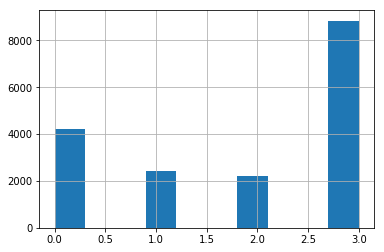

In [47]:
final_pred = pred_test_2
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

In [48]:
print(final_pred)

[3 3 3 3 3 3 2 2 0 0 3 2 3 3 0 1 3 3 3 3 3 3 3 3 0 0 3 0 3 3 0 2 0 0 3 3 0
 1 3 0 2 2 0 1 3 3 2 0 3 3 0 0 3 3 3 0 0 3 1 0 3 2 0 3 0 3 3 3 1 0 2 3 1 1
 3 3 2 3 3 1 1 1 3 3 2 3 3 0 3 3 3 2 2 0 0 3 3 1 0 2 3 0 3 2 0 3 2 3 3 3 1
 3 2 3 1 2 1 3 3 0 3 3 1 3 3 0 3 3 3 3 3 0 1 2 3 3 3 0 0 3 3 3 0 0 3 3 0 3
 2 2 1 0 2 0 3 0 3 0 2 3 2 0 3 3 0 3 3 0 3 0 1 2 3 3 3 3 1 3 0 0 3 0 0 0 2
 1 3 1 3 3 3 1 0 0 2 3 1 0 1 3 3 3 0 0 3 0 3 0 2 2 3 0 0 3 3 2 3 1 0 0 2 3
 3 0 0 3 3 0 3 1 0 3 3 3 3 3 1 1 3 2 1 0 3 2 3 3 3 3 0 0 3 2 3 1 3 3 0 3 3
 3 0 3 3 0 1 3 3 3 0 1 0 2 3 0 0 3 0 0 3 2 3 3 0 2 1 3 2 0 3 3 3 3 1 0 3 3
 1 3 3 3 0 3 0 0 3 1 3 3 3 3 3 2 3 0 1 3 3 2 0 3 3 2 3 3 3 3 3 1 2 2 2 0 0
 3 1 3 3 1 1 0 3 2 1 0 0 3 3 0 2 3 3 0 3 3 3 3 3 3 0 3 1 3 3 3 3 3 3 3 3 3
 3 1 2 3 2 2 3 0 3 3 3 3 3 0 2 0 3 0 1 3 2 3 1 3 3 0 3 1 0 3 3 3 1 2 3 1 1
 3 2 3 1 1 3 2 3 2 0 3 0 0 1 0 3 2 0 3 3 3 1 2 3 0 3 0 3 2 3 0 0 2 3 0 1 2
 0 0 0 3 3 0 0 3 3 3 3 1 3 3 1 2 1 0 3 3 3 3 0 3 0 3 3 3 3 3 2 3 1 3 1 0 3
 3 3 3 2 0 3 3 0 3 0 3 0 

In [49]:
sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)

3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

# Blending models

In [50]:
#weights = {'lbg': 0.75, 'cat': 0.05, 'xgb': 0.10, 'nn': 0.1}

#final_pred = (lgb_model.y_pred * weights['lbg']) +(cat_model.y_pred * weights['cat']) +(xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
#print(final_pred.shape)

In [51]:
#pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)